# Part 2 - Data Visualization using dimensionality reduction

To succesfully learn from your data, you need to know it. Dimension-reduction is a great tool to help analyze high dimensional data. It can help us to see the data in two or three dimensions and analyze clusters or structures. It can also be used to reduce the number of dimensions before processing the data using machine learning algorithms. This can greatly decrease the computational load optimally without losing much information about the data. In these tasks, you will learn how to use dimensionality reduction techniques to visualize the GalaxyMNIST dataset.

In [1]:
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import urllib
import shutil
import gzip
import scipy

try:
    from galaxy_mnist import GalaxyMNIST
except ImportError:
    !pip install git+https://github.com/mwalmsley/galaxy_mnist.git
    from galaxy_mnist import GalaxyMNIST

download_data = [{"url":"https://www.dropbox.com/scl/fi/l4ap5eq7z49l27dnfw076/train_dataset.hdf5.gz?rlkey=gjfrrrouoah0hbydbkpfx66as&st=tw6znd55&dl=1", "zipfile": "train_dataset.hdf5.gz", "file": "train_dataset.hdf5"},
{"url": "https://www.dropbox.com/scl/fi/ty43vhrrpa8cf8azn3awn/test_dataset.hdf5.gz?rlkey=jmlkzjiguhe271nbuzpa0njna&st=5oco8ika&dl=1", "zipfile": "test_dataset.hdf5.gz","file": "test_dataset.hdf5"}]

root_folder = Path("raw_galaxy_mnist")
download_folder = root_folder / "GalaxyMNIST" / "raw"
download_folder.mkdir(parents=True, exist_ok=True)
for info in download_data:
    if not (download_folder / info["zipfile"]).exists():
        urllib.request.urlretrieve(info["url"], download_folder / info["zipfile"])
    if not (download_folder / info["file"]).exists():
      with gzip.open(download_folder / info["zipfile"], 'rb') as f_in:
          with open(download_folder / info["file"], 'wb') as f_out:
              shutil.copyfileobj(f_in, f_out)

dataset = GalaxyMNIST(root=root_folder, train=True)
val_dataset = GalaxyMNIST(root=root_folder, train=False)
# Extract data and targets
raw_images, labels = dataset.data, dataset.targets
raw_test_images, test_labels = val_dataset.data, val_dataset.targets

## 2.1 Reducing Dimensions to Reduce Computational Cost

PCA scales cubically with the number of dimensions because a matrix of size `n_features x n_features` needs to be diagonalized.
- How many entries does this matrix have when using full resolution GalaxyMNIST images?

To ease the burden on your CPU, you can down-scale the data either by transforming the images to gray-scale, down-sampling the images to 32x32 resolution or doing both. We recommend going to gray-scale for powerful/newer CPUs and doing both for less powerful ones.
- Implement one of these options. You can use torchvision transforms.
- By what factor do the methods reduce the number of features and what is the expected speedup?

Using full resolution GalaxyMNIST we have 8000 x 3 x 64 x 64 resolutions

In [ ]:
# Normalize and flatten the images
images = (raw_images.double() - raw_images.double().mean()) / raw_images.double().std()
flattened_images = images.flatten(1).numpy()     # flattens all dimensions except the first (batch) dimension, i.e., flattens each image individually, equivalent to images.view(N, -1)

test_images = (raw_test_images.double() - raw_test_images.double().mean()) / raw_test_images.double().std()
flattened_test_images = test_images.flatten(1).numpy()
print(f"{images.mean()=}, {images.std()=}, {images.min()=}, {images.max()=}")

images.mean()=tensor(-1.2286e-17, dtype=torch.float64), images.std()=tensor(1.0000, dtype=torch.float64), images.min()=tensor(-1.0793, dtype=torch.float64), images.max()=tensor(8.7632, dtype=torch.float64)


## 2.2 Principal Component Analysis (PCA)

### 2.2.1 PCA Algorithm
- Implement the PCA algorithm. It should return the transformed data points, all principal components (eigenvectors) and all eigenvalues.

PCA projects data points linearly into a lower-dimensional hyperplane. It learns a transformation matrix **W** of shape *(n × d)*, where **d < n**, such that the transformation $z = xW$
maps each *n*-dimensional centered sample **x** to its corresponding *d*-dimensional projection **z**.

The columns of matrix **W** consist of the top *d* eigenvectors of the **covariance matrix** of the **centered** data:
$$\Sigma = XX^\top$$

Thus, dimensionality can be reduced from *n* to *d* by projecting the data onto the hyperplane defined by the **first d eigenvectors** of the covariance matrix **Σ**.


In [5]:
def pca(X, d):
    
    X_centered = X - X.mean(axis=0)     # axis = 0 Compute the mean down the rows, for each column (i.e. for each feature)

    # covariance calcul
    covariance_matrix = np.cov(X_centered, rowvar=False)  # X@X^T shape (n x n)

    # Eigenvector, eigenvalue calcul
    eigenvalues, eigenvectors = np.linalg.eigh(covariance_matrix)

    # Sort eigenvectors by descending eigenvalues
    sorted_indices = np.argsort(eigenvalues)[::-1]
    top_d_indices = sorted_indices[:d]
    W = eigenvectors[:, top_d_indices]  # Transformation matrix (n_features, d) = (64 x 64, d)

    # Project data onto low-dimensional subspaces
    Z = X_centered @ W  # Shape: (n_samples, d)

    return Z, W, eigenvalues

In [6]:
transformed_images, Projection_matrix, eigenvalues = pca(flattened_test_images, 8)

### 2.2.2 PCA Visualization
PCA can be used to create visualizations as well as analyze variance in the data. Use your PCA implementation to create the following plots:
- So-called scree plot, where you plot the eigenvalues against the number of components (use all eigenvalues).
- Explained variance plot, the variance explained by all components up to the n-th component divided by the total variance (use all eigenvalues).
- Dimension reduction plots. Use the data projected onto the first and second principal components to create a scatter plot. Color the points according to their true labels. Can you see which classes similar to each other from the plot? Bonus: Create a 3D plot with the first three principal components.
- Visualize the first few principal components (eigenvectors) as images. You can reshape the components to the original image dimensions and plot them.

***Bonus Note**: If you are unsure whether your implementation is correct, you may compare the principal components obtained by your implementation, $\{v_i\}_i$, with those obtained by the [scikit-learn PCA implementation](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html), $\{u_i\}_i$.**
- *Are they completely different? Then your implementation is likely incorrect.*
- *Are they equal? Then your implementation is likely correct.*
- *Do some differ only in sign, i.e., $v_i = -u_i$? Then your implementation is probably correct. But why do they differ in sign?*

***This note is intended as a sanity check and is neither necessary nor mandatory.***

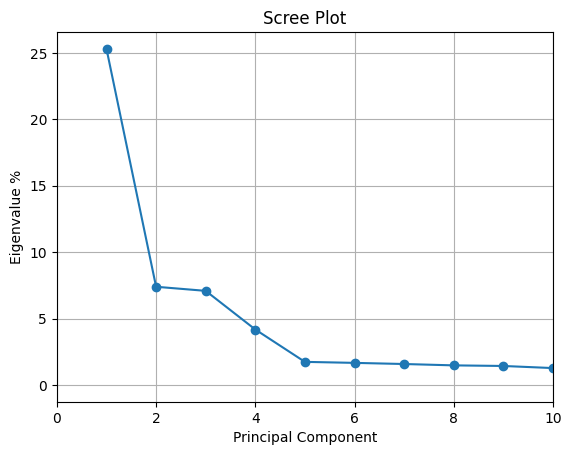

In [29]:
plt.figure()
plt.plot((np.arange(1, len(eigenvalues)+1))[::-1], eigenvalues / eigenvalues.sum() * 100, marker='o')
plt.xlim(0, 10)

plt.title("Scree Plot")
plt.xlabel("Principal Component")
plt.ylabel("Eigenvalue %")
plt.grid(True)

plt.show()

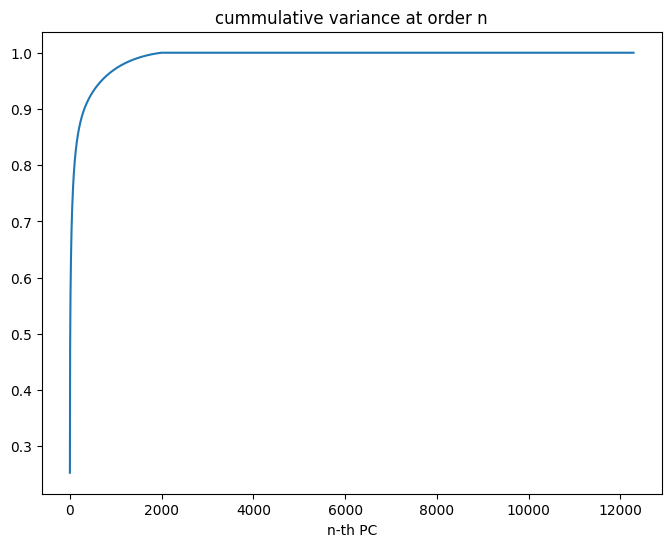

In [38]:
# explained variance
exp_var = [ev/np.sum(eigenvalues) for ev in eigenvalues]

cum_sum_exp = np.cumsum(exp_var[::-1])
plt.figure(figsize=(8,6))
plt.plot((range(eigenvalues.shape[0])), cum_sum_exp)
plt.title('cummulative variance at order n')
plt.xlabel('n-th PC')

plt.show()

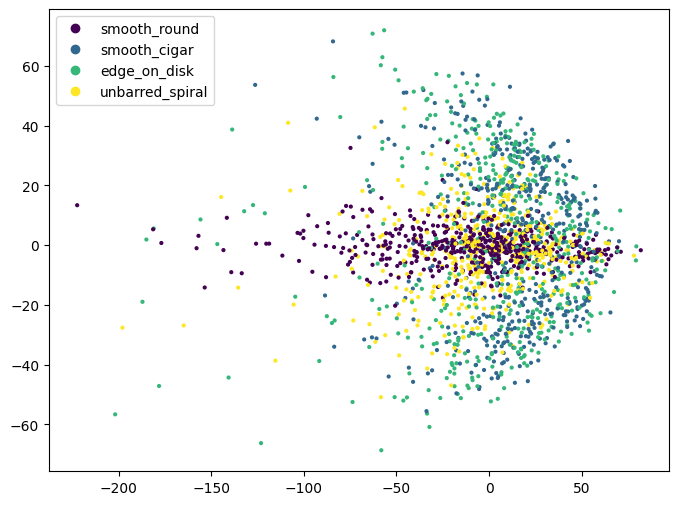

In [40]:
# dimension reduction 2d
plt.figure(figsize=(8,6))
scatter_plot = plt.scatter(transformed_images[:, 0], transformed_images[:, 1], c=test_labels, s=4)
plt.legend(scatter_plot.legend_elements()[0], dataset.classes)

plt.show()

We can clearly distinguish the smooth_round galaxies from the others, as they are primarily distributed along the first principal component. However, it is difficult to separate smooth_cigar galaxies from edge-on disk galaxies, as they scatter in similar directions and overlap significantly. The unbarred spiral galaxies lie between these two distributions, making their separation less distinct.

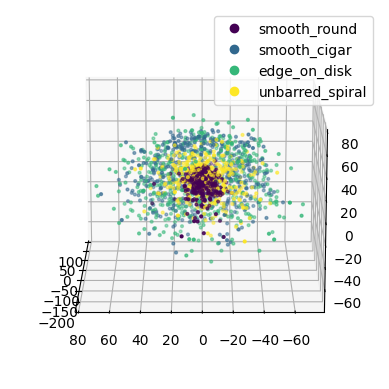

In [ ]:
# dimension reduction 3d
plt.figure()
ax = plt.subplot(projection='3d')
scatter_plot = ax.scatter(transformed_images[:, 0], transformed_images[:, 1], transformed_images[:, 2], c=test_labels, s=4)
plt.legend(scatter_plot.legend_elements()[0], dataset.classes)

ax.view_init(15, 180)  # viewing angle

plt.show()

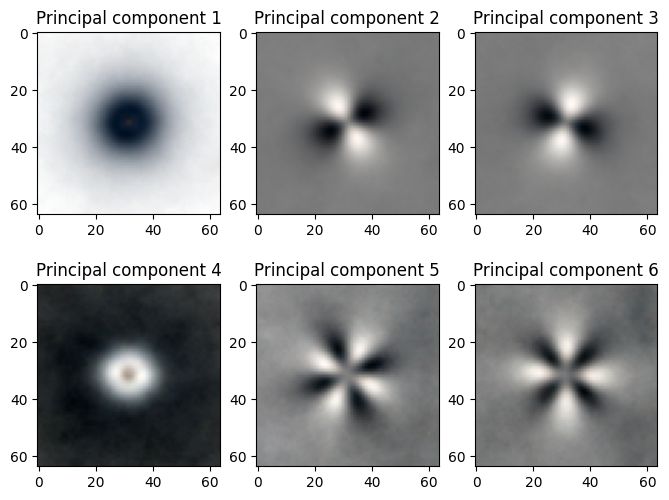

In [46]:
# visualization of principal components

plt.figure(figsize=(8, 6))

for i in range(6):
    ax = plt.subplot(2, 3, i+1)
    vector = Projection_matrix[:, i].reshape(3, 64, 64).transpose(1, 2, 0)
    vector = vector -np.min(vector)    # scales all pixel values to the range [0, 1] (min-max-normalisation), avoid negative and for grayscale or RGB images, Matplotlib expects pixel values in [0, 1] for floats
    
    vector = vector/np.max(vector)
    ax.imshow(vector)
    ax.set_title(f"Principal component {i+1}")

plt.show()

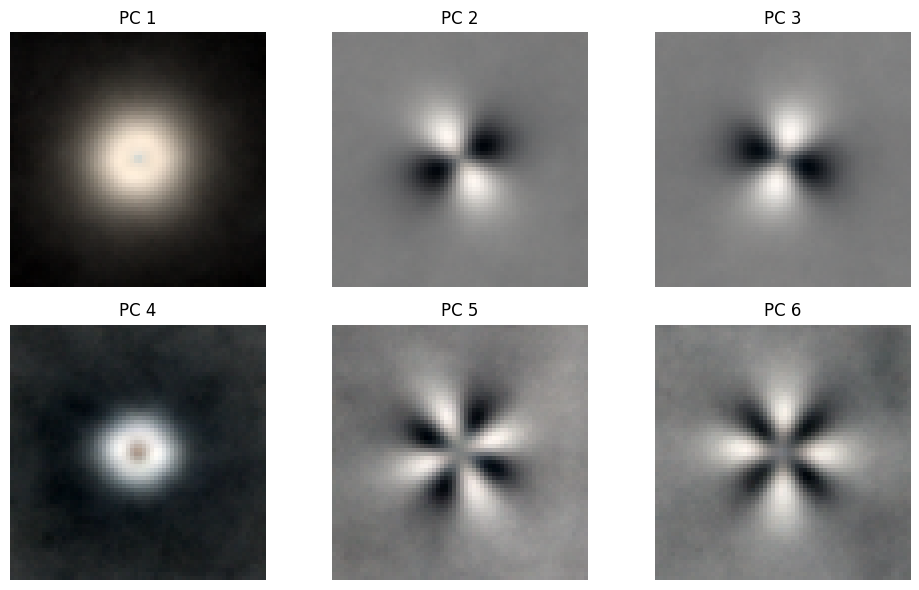

In [ ]:
# Compare with scikit-learn PCA implementation
from sklearn.decomposition import PCA

# Fit PCA
sklearn_pca = PCA()
sklearn_pca.fit(flattened_test_images)
components = sklearn_pca.components_  # shape: (n_components, 12288)

# Plot first 6 principal components as RGB images
fig, axes = plt.subplots(2, 3, figsize=(10, 6))
for i, ax in enumerate(axes.flat[:6]):
    pc_image = components[i].reshape(3, 64, 64).transpose(1, 2, 0)  # (H, W, C)

    # min-max Normalize for display (scale to [0, 1]) as above
    pc_image -= pc_image.min()
    pc_image /= pc_image.max()

    ax.imshow(pc_image)
    ax.set_title(f"PC {i+1}")
    ax.axis('off')

plt.tight_layout()
plt.show()

## 2.3 t-SNE  and UMAP
Two more advanced techniques for dimensionality reduction are t-SNE and UMAP. You will now try both of these methods on the GalaxyMNIST dataset.
### 2.3.1 t-SNE
- Use t-SNE to visualize the GalaxyMNIST dataset. Plot the first and second components of the t-SNE projection against each other. Color the points according to their true labels.
- Play with the hyperparameters and see how they affect the visualization ([this](https://distill.pub/2016/misread-tsne/) is a nice source).
- Which classes are easier or more difficult to separate from each other?

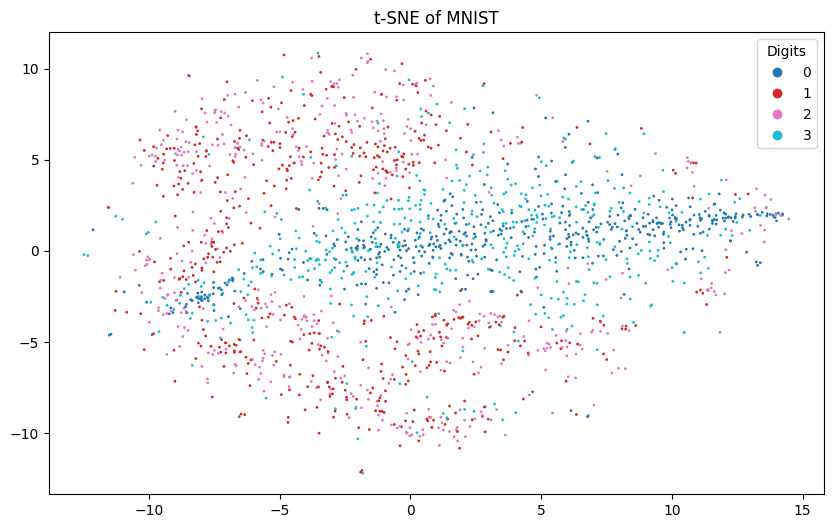

In [ ]:
from sklearn.manifold import TSNE

# Apply t-SNE
tsne = TSNE(n_components=2, perplexity=150, max_iter=5000)
X_tsne = tsne.fit_transform(flattened_test_images)     # X_tsne shape (N_samples, 2)

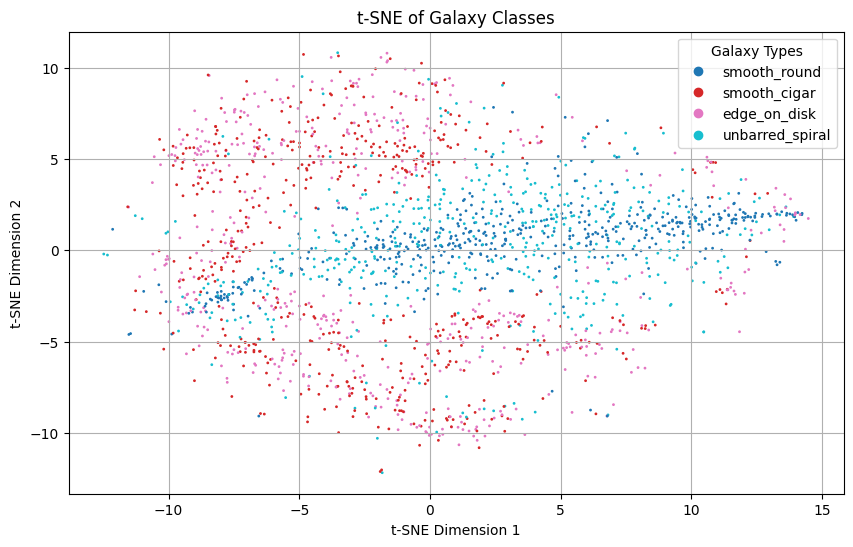

In [60]:
class_names = ["smooth_round", "smooth_cigar", "edge_on_disk", "unbarred_spiral"]

plt.figure(figsize=(10, 6))
scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=test_labels.numpy().astype(int), cmap='tab10', s=1)

# Create a custom legend with galaxy class names
handles, indices = scatter.legend_elements()
plt.legend(handles, class_names, title="Galaxy Types")

plt.title('t-SNE of Galaxy Classes')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.grid(True)
plt.show()

n_components = 2 reduces high-dim datasets to 2 dimensions for plotting in 2D, perplexity controls the balance between local and global structure. Higher = more global. max_iter is the number of optimization steps (default is 1000 — 5000 gives smoother results). The smooth_round galaxies are centered around similar y-values, which makes them easy to identify—similar to what we observe with PCA in 2D. The unbarred_spiral galaxies are positioned between the cigar-shaped and smooth_round galaxies. However, distinguishing cigar-shaped galaxies from edge-on disks remains challenging.

### 2.3.2 UMAP
- Briefly read about UMAP. Would a different dataset normalization yield different visualizations?
- Use UMAP to visualize the GalaxyMNIST dataset. Plot the first and second components of the UMAP projection against each other. Color the points according to their true labels.
- Play with the hyperparameters and see how they affect the visualization.

In [61]:
import umap
test_umap = umap.UMAP(n_components=2, min_dist=0.5, n_neighbors=30).fit_transform(flattened_test_images)

c:\Users\shiy0\OneDrive\Dokumente\FP\S10 maschine learning\mlfp\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Learns a 2D embedding (n_components=2) that preserves structure in the data. min_dist controls how tightly UMAP packs the points: with small value we got tighter clusters and with large value more structure spread out. n_neighbor is the number of neighbors considered for each point in high-dimensional space, if it is small local relationships are more recognizable, while large values preserves global structure.

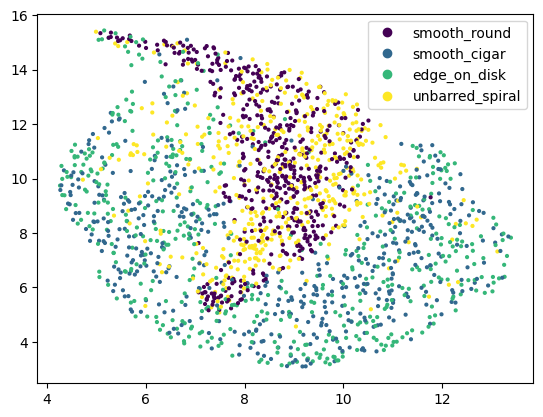

In [62]:
plt.figure()
scatter_plot_umap = plt.scatter(test_umap[:, 0], test_umap[:, 1], c=test_labels, s=4)
plt.legend(scatter_plot_umap.legend_elements()[0], dataset.classes)

plt.show()

## 2.4 Identifying Regions
In your UMAP or t-SNE plot, you can probably see some specific regions.
- Choose at least two regions, identify some samples inside them plot the original images.
- What do images in the same region share?
- Bonus: Create a large image of images in the latent space. This can be done by finding the nearest neighbors in the latent space and plotting the images in a grid.

In [63]:
# region 1: umap around (8, 9)
region_1_images_idx = (9>=test_umap[:,0])&(test_umap[:,0]>=8)&(11>=test_umap[:,1])&(test_umap[:,1]>=10)      # Boolean mask
region_1_images = raw_test_images[region_1_images_idx]

# region 2: umap around (5, 6)
region_2_images_idx = (6>=test_umap[:,0])&(test_umap[:,0]>=5.5)&(10.5>=test_umap[:,1])&(test_umap[:,1]>=9.5)
region_2_images = raw_test_images[region_2_images_idx]

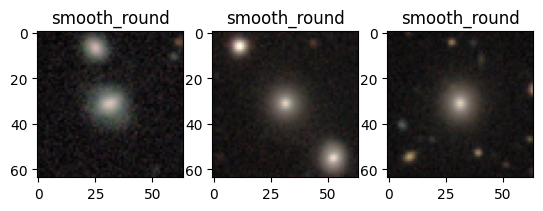

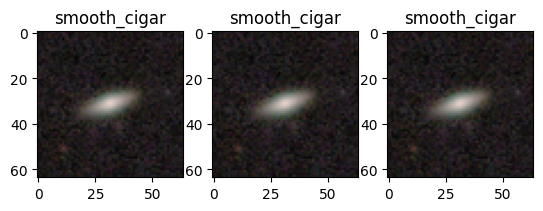

In [65]:
plt.figure()

for i,j in enumerate(np.random.randint(0, len(region_1_images), 3)):
    
    ax = plt.subplot(1, 3, i+1)
    ax.imshow(region_1_images[j].permute(1, 2, 0))
    ax.set_title(dataset.classes[test_labels[region_1_images_idx][j]])

plt.show()

plt.figure()

for i,j in enumerate(np.random.randint(0, len(region_2_images), 3)):
    
    ax = plt.subplot(1, 3, i+1)
    ax.imshow(region_2_images[j].permute(1, 2, 0))
    ax.set_title(dataset.classes[test_labels[region_2_images_idx][j]])

plt.show()